In [1]:
import torch
print(torch.__version__)

2.0.1


In [2]:
# Load Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root=".", name="ESOL")
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 32
loader = DataLoader(data[:int(data_size * 0.7)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)
test_loader = DataLoader(data[int(data_size * 0.7):int(data_size * 0.9)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)


C:\Users\illew\anaconda3\envs\rdkit_tf-gpu\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# Embed SMILES into numbers

# Get set of characters
chars = set()
for i in data.smiles:
    for letter in i:
        chars.add(letter) 
chars = ['.']+sorted(list(chars))
vocab_size = len(chars)+1 #plus one for padding "end" type char
print('Vocabulary:')
print(''.join(chars))
print(vocab_size)

# Map characters to integers
stoi = {ch:i+1 for i,ch in enumerate(chars)}
itos = {i+1:ch for i,ch in enumerate(chars)}
encode = lambda st: [stoi[ch] for ch in st]
decode = lambda nu: ''.join([itos[int(i)] for i in nu])
print('Encoding Test:')
print(encode('Cc1occc1C(=O)Nc2ccccc2'))
print(decode(encode('Cc1occc1C(=O)Nc2ccccc2')))

Vocabulary:
. #()/12345678=BCFHINOPS[\]clnors
34
Encoding Test:
[17, 28, 7, 31, 28, 28, 28, 7, 17, 4, 15, 22, 5, 21, 28, 8, 28, 28, 28, 28, 28, 8]
Cc1occc1C(=O)Nc2ccccc2


In [4]:
# Get max length for padding
max_length = 0
for i in data.smiles:
    if len(i)>max_length:
        max_length = len(i)
print(max_length)

98


In [5]:
# Add padded encodings to dataset
def add_attributes(dataset):
    data_list = []
    for data in dataset:
        data.encsmiles = encode(data.smiles)+[0 for _ in range(len(encode(data.smiles)),max_length)]
        data_list.append(data)
    dataset.data, dataset.slices = dataset.collate(data_list)
    return dataset

data = add_attributes(data)

In [6]:
# Check encoded smiles
print(len(data[0].encsmiles))
print(data[0].encsmiles)
print(data[0].y)

98
[22, 17, 17, 9, 22, 17, 4, 22, 17, 17, 8, 22, 17, 4, 22, 17, 4, 17, 3, 21, 5, 28, 7, 28, 28, 28, 28, 28, 7, 5, 17, 4, 22, 5, 17, 4, 22, 5, 17, 8, 22, 5, 17, 4, 22, 5, 17, 4, 22, 5, 17, 9, 22, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([[-0.7700]])


In [7]:
# Test batch
batch_size = 32
xb = torch.tensor(data[:batch_size].encsmiles)
yb = data[:batch_size].y
print(xb.size(),yb.size())

torch.Size([32, 98]) torch.Size([32, 1])


In [8]:
# Now the task - to connect sequence [data.encsmiles] to solubility [data.y]
# Framework of sentiment analysis, where the passage is [data.encsmiles] and the sentiment is [data.y]
# https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Linear
torch.manual_seed(1234)

torch.set_default_tensor_type(torch.cuda.FloatTensor)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = max_length):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))

        pe = torch.zeros(1, max_len, d_model) # Batch, Token, Channel 
        pe[0,:,0::2] = torch.sin(position*div_term)
        pe[0,:,1::2] = torch.cos(position*div_term) 
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "model dimensionality d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # dimensions per head
        
        self.W_q = nn.Linear(d_model,d_model)
        self.W_k = nn.Linear(d_model,d_model)
        self.W_v = nn.Linear(d_model,d_model)
        self.W_o = nn.Linear(d_model,d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Get similarities between queries and keys
        attention_scores = Q @ K.transpose(-2,-1) / math.sqrt(self.d_k)
        
        # Mask if present
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax to get proportional weights for value aggregation
        attention_probability = torch.softmax(attention_scores, dim=-1)
        output_values = attention_probability @ V
        return output_values
    
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1,2)
    
    def combine_heads(self, x):
        batch_size, heads, seq_length, d_k = x.size()
        return x.transpose(1,2).contiguous().view(batch_size, seq_length, self.d_model)
    
    def forward(self, embedding, mask=None):
        # Multi head split
        Q = self.split_heads(self.W_q(embedding))
        K = self.split_heads(self.W_k(embedding))
        V = self.split_heads(self.W_v(embedding))
        
        # Attention
        attention_output = self.scaled_dot_product_attention(Q,K,V, mask)
        
        # Merge heads and output
        output = self.W_o(self.combine_heads(attention_output))
        return output
    
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, vocab_size=34, dropout=.1):
        super(Encoder,self).__init__()
        
        # Embedding
        self.embedding = nn.Embedding(vocab_size,d_model)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Attention
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        
        # Linear
        self.linear = Linear(max_length*d_model, 1)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, idx, targets=None):
        # embedding
        logits = self.embedding(idx) # (B,T,C)
        
        # positional encoding 
        logits = self.pos_encoder(logits)
        
        # attention
        attend = self.self_attention(logits)
        
        # residual
        logits = logits + self.dropout(attend)
        logits = self.norm(logits)
        
        # output
        batch_size, seq_length, d_model = logits.size()
        logits = logits.contiguous().view(batch_size, seq_length*d_model)
        output = self.linear(logits)
        loss = F.mse_loss(output,targets)    
        return output, loss 
    
    def generate(self, idx): #trivial here, but left for later generalizability
        logits, loss = self(idx)
        return logits

emb_size = 32
num_heads = emb_size//8
dropout = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
m = Encoder(emb_size, num_heads, vocab_size, dropout).to(device)

xb=xb.to(device)
yb=yb.to(device)
output, loss = m(xb,yb)
# print(output, yb, loss.item())  

print("Number of Parameters: ", sum(p.numel() for p in m.parameters()))
torch.cuda.empty_cache()

Number of Parameters:  8513


In [9]:
# Data loader
batch_size = 32
loader = DataLoader(data[:int(data_size * 0.7)], batch_size=batch_size, shuffle = False)
test_loader = DataLoader(data[int(data_size * 0.7):int(data_size * 0.9)], batch_size=batch_size, shuffle = False)
val_loader = DataLoader(data[int(data_size * 0.9):], batch_size=batch_size, shuffle = False)

val = data[int(data_size * 0.9):int(data_size * 0.9)+batch_size]
val_encsmiles, val_y = torch.tensor(val.encsmiles, device=device), torch.tensor(val.y, device=device)

C:\Users\illew\AppData\Local\Temp/ipykernel_21216/150668724.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_encsmiles, val_y = torch.tensor(val.encsmiles, device=device), torch.tensor(val.y, device=device)


In [10]:
### Hyperparameter Search via Bayesian Optimization

# Helper functions

# Search Space: embedding size(halved), num_heads, dropout
emb_range = [1,8] # will be multiplied by 2 to enforce evens only
heads_range = [1,16]
dropout_range = [0,1]

# Objective Function:
    # takes in hyper parameters
    # creates model
    # trains model
    # evaluates model on full validation set
    # returns final validation error

# Objective function to optimize: Transformer encoder
def objective(X, Y=[[10]]):
    emb_per_head = X[0]
    num_heads = X[1]
    dropout = X[2]
    
    # Create Model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    m = Encoder(num_heads*emb_per_head, num_heads, 34, dropout).to(device)
    optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
    print('Model created with', num_heads, 'heads,', emb_per_head, 'dimensions per head, and', dropout, 'dropout.')
    
    # Train Model
    for epoch in range(200):
        for batch in loader:
            batch = batch.to(device)
            property_prediction, loss = m(torch.tensor(batch.encsmiles), batch.y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(epoch,loss.item())
    
    # Validation Loss
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            val_property_prediction, val_loss = m(torch.tensor(batch.encsmiles), batch.y)
            val_losses.append(val_loss)
    avg_val_loss = sum(val_losses)/len(val_losses)
    print('Validation loss:', avg_val_loss.item())
    
    if avg_val_loss <= min(Y)[0]:
        torch.save(m,'011023_BO_tenc.pt')
    
    return avg_val_loss

# Surrogate function for Bayesian optimization: 
    # Common types include Gaussian Process, Random Forest, Tree-structured Parzen Estimator...
    # Here we use gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
def surrogate(model, X):
    # Returns mean and std for stack of historical hyperparameters X
    return model.predict(X, return_std=True) 
    
# Acquisition function for scoring exploration: 
    # Common types include Probability of Improvement, Expected Improvement, Lower Confidence Bound
    # Evaluates liklihood that given candidate sample is worth evaluating with real objective function
from scipy.stats import norm
def acquisition(X, Xsample, model):
    # For previous hyperparameters [X], new proposed hyperparameters [Xsamples], surrogate model [model]
    # Get score of whether new hyperparameters are worthy to check
    
    # Current best hyperparameter performance
    old_mean, old_std = surrogate(model, X) 
    best_mean = min(old_mean)
    
    # New hyperparameter performance
    new_mean, new_std = surrogate(model, Xsample)
    probability = norm.cdf((new_mean - best_mean)/(new_std + 1e-9))
    return probability

# Selection function for potential acquisitions:
    # Common types include random and grid selection
    # Here, random is implemented
import random
def selection(X, model):
    scores = {}
    for samples in range(100):
        Xsample = [[random.randint(emb_range[0],emb_range[1])*2, random.randint(heads_range[0],heads_range[1]), random.uniform(dropout_range[0],dropout_range[1])]] # num_heads, emb_per_head, dropout
        scores[tuple(Xsample[0])] = acquisition(X,Xsample,model)
    best_hyper = min(zip(scores.values(),scores.keys()))[1]
    return list(best_hyper)


In [41]:
# Driver for Bayesian Optimization 

# Initialize surrogate model
X = []
for samples in range(10):
    X.append([random.randint(emb_range[0],emb_range[1])*2, random.randint(heads_range[0],heads_range[1]), random.uniform(dropout_range[0],dropout_range[1])]) # num_heads, emb_per_head, dropout
Y = [[objective(x)] for x in X]
model = GaussianProcessRegressor()
model.fit(X,Y)

# Updates to surrogate model
from numpy import vstack
for iteration in range(100):
    # Select the next point to sample with objective function
    x = selection(X, model)
    # Sample the objective function
    actual = objective(x, Y)
    # Print findings
    est, s = surrogate(model, [x])
    print(iteration,'Selected hyperparameters:',x,'Estimated Loss:',est[0][0],'Real Loss:',actual.item())
    # Update dataset and surrogate model
    X = vstack((X,[x]))
    Y = vstack((Y,[[actual]]))
    model.fit(X,Y)

# Final result
out_hyper = min(zip(Y,X))[1]

Model created with 2 heads, 4 dimensions per head, and 0.6210600561452275 dropout.
0 3.129314661026001
10 0.8885423541069031
20 0.5401342511177063
30 0.7239106297492981
40 0.6235337853431702
50 0.44746172428131104
60 0.6620482802391052
70 0.9279161095619202
80 0.5544934272766113
90 0.6160069108009338
100 0.6133071780204773
110 0.5373317003250122
120 0.545931339263916
130 0.3655525743961334
140 0.40236565470695496
150 0.5721831917762756
160 0.47537437081336975
170 0.48329514265060425
180 0.702710747718811
190 0.4674127697944641
Validation loss: 0.9918512105941772
Model created with 10 heads, 2 dimensions per head, and 0.03727480756531776 dropout.
0 3.9929847717285156
10 0.8542195558547974
20 0.3921286463737488
30 1.0414977073669434
40 0.26055485010147095
50 0.3400370478630066
60 0.2099018096923828
70 0.13082768023014069
80 0.1825283020734787
90 0.23830664157867432
100 0.22419852018356323
110 0.18883894383907318
120 0.11005659401416779
130 0.25626352429389954
140 0.09912186861038208
150 

130 0.46467941999435425
140 0.489920973777771
150 0.30273473262786865
160 0.34952813386917114
170 0.5164046883583069
180 0.5003222227096558
190 0.22028085589408875
Validation loss: 0.8237929940223694
3 Selected hyperparameters: [8, 12, 0.7999192737221701] Estimated Loss: 5.790694844949568e-07 Real Loss: 0.8237929940223694
Model created with 1 heads, 10 dimensions per head, and 0.18327773301761485 dropout.
0 4.203772068023682
10 0.6936897039413452
20 0.6877137422561646
30 0.6889724731445312
40 0.7370103597640991
50 0.723759114742279
60 0.45986050367355347
70 0.5273692607879639
80 0.4696061313152313
90 0.7215970754623413
100 0.608544111251831
110 0.5683578252792358
120 0.2693885564804077
130 0.43668773770332336
140 0.3163004517555237
150 0.42597249150276184
160 0.291151225566864
170 0.19655674695968628
180 0.3314732313156128
190 0.337778776884079
Validation loss: 0.9285274147987366
4 Selected hyperparameters: [10, 1, 0.18327773301761485] Estimated Loss: 3.3081228781558365e-05 Real Loss: 

70 0.32050269842147827
80 0.18088746070861816
90 1.0642765760421753
100 0.19048437476158142
110 0.12955808639526367
120 0.20685788989067078
130 0.19017350673675537
140 0.18190382421016693
150 0.17697523534297943
160 0.1548847109079361
170 0.10879547148942947
180 0.06725029647350311
190 0.3087940216064453
Validation loss: 1.2174586057662964
15 Selected hyperparameters: [10, 14, 0.0596847599455379] Estimated Loss: 0.03405603986008386 Real Loss: 1.2174586057662964
Model created with 13 heads, 4 dimensions per head, and 0.820168273741111 dropout.
0 16.703418731689453
10 2.114781379699707
20 1.0051857233047485
30 0.28565481305122375
40 0.6496890783309937
50 0.5493249893188477
60 0.559224009513855
70 0.31669682264328003
80 0.3705795407295227
90 0.2754001319408417
100 0.44104912877082825
110 0.22644168138504028
120 0.5401257872581482
130 0.22725138068199158
140 0.3640102744102478
150 0.2956906855106354
160 0.3745482265949249
170 0.14954914152622223
180 0.3235599100589752
190 0.350058108568191

0 36.888858795166016
10 3.6707763671875
20 2.540130376815796
30 1.840556025505066
40 0.9163954854011536
50 0.8082001209259033
60 0.7851095795631409
70 0.7580246329307556
80 0.5935381650924683
90 0.7247492671012878
100 0.656252920627594
110 0.5185921788215637
120 0.34991878271102905
130 0.3129384219646454
140 0.2907581925392151
150 0.4961710572242737
160 0.3765864074230194
170 0.6616641879081726
180 0.23846633732318878
190 0.5442265272140503
Validation loss: 1.0934500694274902
27 Selected hyperparameters: [16, 8, 0.7648887886761243] Estimated Loss: 0.19639740531460176 Real Loss: 1.0934500694274902
Model created with 4 heads, 10 dimensions per head, and 0.2147792227887877 dropout.
0 8.722143173217773
10 0.6688010692596436
20 1.139418125152588
30 0.3529220521450043
40 1.0995802879333496
50 0.21223461627960205
60 0.17331203818321228
70 0.1349109560251236
80 0.23027543723583221
90 0.34467625617980957
100 0.1701975017786026
110 0.11416415125131607
120 0.1803189218044281
130 0.318156987428665

0 12.780953407287598
10 2.365168333053589
20 1.8625540733337402
30 1.087505578994751
40 0.9817621111869812
50 0.7740575671195984
60 0.5136865377426147
70 0.7420762777328491
80 0.6497557759284973
90 0.7729532122612
100 0.6302874088287354
110 0.4500232934951782
120 0.560550332069397
130 0.7096766829490662
140 0.619707465171814
150 0.853278398513794
160 0.7283875942230225
170 0.8159453868865967
180 0.30607181787490845
190 0.9318698048591614
Validation loss: 1.8020912408828735
39 Selected hyperparameters: [16, 3, 0.9222383707214354] Estimated Loss: 0.3894890765833131 Real Loss: 1.8020912408828735
Model created with 16 heads, 14 dimensions per head, and 0.4917613828077194 dropout.
0 290.5881652832031
10 8.79041576385498
20 3.3199498653411865
30 3.9115593433380127
40 2.5978105068206787
50 6.177531719207764
60 2.2225563526153564
70 1.3890674114227295
80 2.9516642093658447
90 1.2557941675186157
100 0.8023875951766968
110 0.7473366260528564
120 0.6282666325569153
130 0.33577802777290344
140 0.4

0 8.297420501708984
10 2.5460684299468994
20 1.1957906484603882
30 0.7194837927818298
40 0.48030391335487366
50 0.38145238161087036
60 0.4870482087135315
70 0.4782376289367676
80 0.49301356077194214
90 0.5223873257637024
100 0.4820299744606018
110 0.8336557745933533
120 0.3834737241268158
130 0.2980536222457886
140 0.34907597303390503
150 0.5327146053314209
160 0.6473811268806458
170 0.3357948064804077
180 0.29932349920272827
190 0.4502626657485962
Validation loss: 0.6943259835243225
51 Selected hyperparameters: [2, 13, 0.9450540584956645] Estimated Loss: 0.451277020200628 Real Loss: 0.6943259835243225
Model created with 5 heads, 2 dimensions per head, and 0.30545411954551527 dropout.
0 4.989555835723877
10 0.732159435749054
20 0.5338594913482666
30 0.43133023381233215
40 0.3684835433959961
50 0.43387913703918457
60 0.5827975869178772
70 0.46289682388305664
80 0.5043671131134033
90 0.31268957257270813
100 0.4717077612876892
110 0.33607229590415955
120 0.3708060681819916
130 0.256741106

0 3.860928535461426
10 1.0749027729034424
20 0.7964463233947754
30 0.33631324768066406
40 0.6824442148208618
50 0.6805886626243591
60 0.48324182629585266
70 0.3467573821544647
80 0.40106120705604553
90 0.29651927947998047
100 0.396157830953598
110 0.4712308347225189
120 0.4238556921482086
130 0.33332711458206177
140 0.46367940306663513
150 0.3939841091632843
160 0.30908676981925964
170 0.26300159096717834
180 0.34862250089645386
190 0.30404603481292725
Validation loss: 0.7846804261207581
63 Selected hyperparameters: [2, 4, 0.2888662355758036] Estimated Loss: 0.06143984942127645 Real Loss: 0.7846804261207581
Model created with 6 heads, 2 dimensions per head, and 0.4609343876409926 dropout.
0 6.383755207061768
10 0.8842459321022034
20 1.7284427881240845
30 0.6336366534233093
40 0.3989292085170746
50 0.4604189693927765
60 0.6481823325157166
70 0.3740968704223633
80 0.21701587736606598
90 0.20558799803256989
100 0.3167508542537689
110 0.3626943826675415
120 0.1994396150112152
130 0.2105162

0 6.1639204025268555
10 1.4762659072875977
20 3.7561607360839844
30 0.31341132521629333
40 0.2349354475736618
50 0.5315492153167725
60 0.1440255343914032
70 0.1456526666879654
80 0.4254378378391266
90 0.09118969738483429
100 0.16137443482875824
110 0.055021025240421295
120 0.17782281339168549
130 0.12983030080795288
140 0.1970740705728531
150 0.1373758763074875
160 0.16274577379226685
170 0.26136624813079834
180 0.20576173067092896
190 0.14552633464336395
Validation loss: 1.099356770515442
75 Selected hyperparameters: [12, 5, 0.017983617992930134] Estimated Loss: 0.6376806921137441 Real Loss: 1.099356770515442
Model created with 5 heads, 2 dimensions per head, and 0.26702229409893474 dropout.
0 6.571736812591553
10 0.7521569728851318
20 0.5461207628250122
30 0.4513630270957947
40 0.37478893995285034
50 0.3263038992881775
60 0.2664489448070526
70 0.33168870210647583
80 0.30141332745552063
90 0.1671837717294693
100 0.31480586528778076
110 0.2580408751964569
120 0.2929043471813202
130 0.3

0 6.555551052093506
10 1.23695707321167
20 1.2423465251922607
30 0.594635546207428
40 0.8892114162445068
50 0.7918274402618408
60 0.6462154388427734
70 0.773669421672821
80 0.7102941274642944
90 0.7570218443870544
100 0.4128968417644501
110 0.801059365272522
120 0.843647837638855
130 0.6257211565971375
140 0.612185537815094
150 0.8797995448112488
160 0.7615813612937927
170 0.7575874328613281
180 0.6027777791023254
190 0.5723839998245239
Validation loss: 0.8238431811332703
87 Selected hyperparameters: [2, 3, 0.7144976435964276] Estimated Loss: 0.12957160593941808 Real Loss: 0.8238431811332703
Model created with 7 heads, 2 dimensions per head, and 0.06729310762183116 dropout.
0 6.072783946990967
10 0.5582147240638733
20 0.44293567538261414
30 0.3552539348602295
40 0.22387370467185974
50 0.3315199017524719
60 0.2979641258716583
70 0.15673112869262695
80 0.10998483002185822
90 0.17559988796710968
100 0.2243058681488037
110 0.20325277745723724
120 0.31368014216423035
130 0.16062253713607788

0 2.4593870639801025
10 0.574150800704956
20 0.5455332398414612
30 0.3280576169490814
40 0.19343426823616028
50 0.2289830446243286
60 0.3039708733558655
70 0.5945853590965271
80 0.25536447763442993
90 0.3646804392337799
100 0.34366539120674133
110 0.2237040400505066
120 0.2869998812675476
130 0.24293366074562073
140 0.3153459429740906
150 0.29092225432395935
160 0.22696945071220398
170 0.2928948998451233
180 0.41657567024230957
190 0.3037945628166199
Validation loss: 0.9634094834327698
99 Selected hyperparameters: [2, 9, 0.4395200565141957] Estimated Loss: -1.2483116492803674 Real Loss: 0.9634094834327698


In [11]:
# Load model
m = torch.load('011023_BO_tenc.pt')

# Inference
def inference(model, loader):
    reals = []
    predicteds = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            property_prediction, loss = m(torch.tensor(batch.encsmiles), batch.y)
            for i,j in zip(property_prediction, batch.y):
                predicteds.append(i.item())
                reals.append(j.item())
    return reals, predicteds
    
train_real, train_pred = inference(m, loader)
test_real, test_pred = inference(m, test_loader)   

TRAIN - MSE: 0.27078356467084097 R2: 0.9375495042233242
TEST - MSE: 0.9069408391798951 R2: 0.8111751164839524


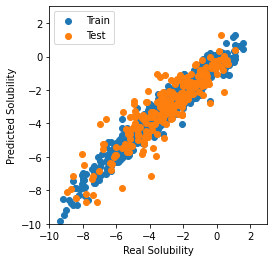

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Plotting
fig,ax = plt.subplots()
plt.scatter(train_real, train_pred)
plt.scatter(test_real, test_pred)

# Formatting
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
ax.legend(['Train', 'Test'])
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
ax.set_xlim(-10,3)
ax.set_ylim(-10,3)

print('TRAIN - MSE:',mean_squared_error(train_real, train_pred),'R2:',r2_score(train_real, train_pred))
print('TEST - MSE:',mean_squared_error(test_real, test_pred),'R2:',r2_score(test_real, test_pred))


In [68]:
# Long Train with Optimized Hyperparameters
X = out_hyper
emb_per_head = int(X[0])
num_heads = int(X[1])
dropout = X[2]

# Create Model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = Encoder(num_heads*emb_per_head, num_heads, 34, dropout).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
print('Model created with', num_heads, 'heads,', emb_per_head, 'dimensions per head, and', dropout, 'dropout.')

# Train Model
avg_val_loss_list = []
loss_list = []
for epoch in range(3000):
    for batch in loader:
        batch = batch.to(device)
        property_prediction, loss = m(torch.tensor(batch.encsmiles), batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation Loss
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            val_property_prediction, val_loss = m(torch.tensor(batch.encsmiles), batch.y)
            val_losses.append(val_loss)
    avg_val_loss = sum(val_losses)/len(val_losses)
    avg_val_loss_list.append(avg_val_loss.item())
    loss_list.append(loss.item())
    
    # Document
    if avg_val_loss.item() <= min(avg_val_loss_list):
        torch.save(m,'021023_BO_full_tenc.pt')
    if epoch % 10 == 0:
        print('Epoch',epoch,'Training loss:',loss.item(),'Validation loss:', avg_val_loss.item())



Model created with 1 heads, 14 dimensions per head, and 0.028735707903757235 dropout.
Epoch 0 Training loss: 7.850566387176514 Validation loss: 3.1464104652404785
Epoch 10 Training loss: 0.9807190895080566 Validation loss: 1.0402095317840576
Epoch 20 Training loss: 0.3001972436904907 Validation loss: 1.2151854038238525
Epoch 30 Training loss: 0.7940494418144226 Validation loss: 0.8708635568618774
Epoch 40 Training loss: 0.29379206895828247 Validation loss: 0.9403162598609924
Epoch 50 Training loss: 0.4546448588371277 Validation loss: 0.8700158596038818
Epoch 60 Training loss: 0.43224743008613586 Validation loss: 0.9181358218193054
Epoch 70 Training loss: 0.3138313889503479 Validation loss: 0.9909950494766235
Epoch 80 Training loss: 0.3100060224533081 Validation loss: 0.8716793656349182
Epoch 90 Training loss: 0.22731563448905945 Validation loss: 0.8702148795127869
Epoch 100 Training loss: 0.24553069472312927 Validation loss: 0.9356099367141724
Epoch 110 Training loss: 0.283580511808395

Epoch 1010 Training loss: 0.10548648238182068 Validation loss: 1.1480565071105957
Epoch 1020 Training loss: 0.08782622218132019 Validation loss: 1.0003728866577148
Epoch 1030 Training loss: 0.237579807639122 Validation loss: 1.1755255460739136
Epoch 1040 Training loss: 0.16471342742443085 Validation loss: 1.0547622442245483
Epoch 1050 Training loss: 0.13631893694400787 Validation loss: 0.9254205226898193
Epoch 1060 Training loss: 0.17198824882507324 Validation loss: 1.0539417266845703
Epoch 1070 Training loss: 0.14278607070446014 Validation loss: 0.9611000418663025
Epoch 1080 Training loss: 0.12146350741386414 Validation loss: 1.0973578691482544
Epoch 1090 Training loss: 0.08995124697685242 Validation loss: 1.0550066232681274
Epoch 1100 Training loss: 0.09554073214530945 Validation loss: 1.0541296005249023
Epoch 1110 Training loss: 0.0780305564403534 Validation loss: 1.112302541732788
Epoch 1120 Training loss: 0.19778576493263245 Validation loss: 0.9863878488540649
Epoch 1130 Training 

Epoch 2020 Training loss: 0.21032856404781342 Validation loss: 1.0671167373657227
Epoch 2030 Training loss: 0.1561085432767868 Validation loss: 0.966394305229187
Epoch 2040 Training loss: 0.21499177813529968 Validation loss: 1.0521366596221924
Epoch 2050 Training loss: 0.1542392373085022 Validation loss: 0.9430010318756104
Epoch 2060 Training loss: 0.15025098621845245 Validation loss: 1.1631274223327637
Epoch 2070 Training loss: 0.12047535181045532 Validation loss: 0.984499990940094
Epoch 2080 Training loss: 0.14957188069820404 Validation loss: 1.0125534534454346
Epoch 2090 Training loss: 0.20278145372867584 Validation loss: 0.9118426442146301
Epoch 2100 Training loss: 0.21141016483306885 Validation loss: 0.9737038612365723
Epoch 2110 Training loss: 0.05373329296708107 Validation loss: 0.9547432661056519
Epoch 2120 Training loss: 0.1188988909125328 Validation loss: 0.9595891237258911
Epoch 2130 Training loss: 0.1609198898077011 Validation loss: 0.9820677638053894
Epoch 2140 Training lo

TRAIN - MSE: 0.2705666971103083 R2: 0.9375995201343327
TEST - MSE: 0.7110579085504273 R2: 0.851957899617125
Number of Parameters:  2717


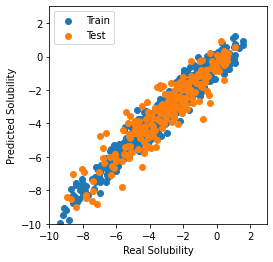

In [14]:
m = torch.load('021023_BO_full_tenc.pt')

# Inference
train_real, train_pred = inference(m, loader)
test_real, test_pred = inference(m, test_loader)  

# Plotting
fig,ax = plt.subplots()
plt.scatter(train_real, train_pred)
plt.scatter(test_real, test_pred)

# Formatting
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
ax.legend(['Train', 'Test'])
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
ax.set_xlim(-10,3)
ax.set_ylim(-10,3)

print('TRAIN - MSE:',mean_squared_error(train_real, train_pred),'R2:',r2_score(train_real, train_pred))
print('TEST - MSE:',mean_squared_error(test_real, test_pred),'R2:',r2_score(test_real, test_pred))
print("Number of Parameters: ", sum(p.numel() for p in m.parameters()))